<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2.5_ML20M%20optimizing%20cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

41.6
svmem(total=13617737728, available=12355424256, percent=9.3, used=1037942784, free=10598879232, active=1432313856, inactive=1374089216, buffers=111529984, cached=1869385728, shared=1220608, slab=135897088)
9.3
90.73037315585462


In [5]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

In [6]:
tf.__version__

'2.8.0'

In [7]:
itemCol = 'movieId'
userCol = 'userId'

In [8]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Mounted at /content/gdrive


In [9]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


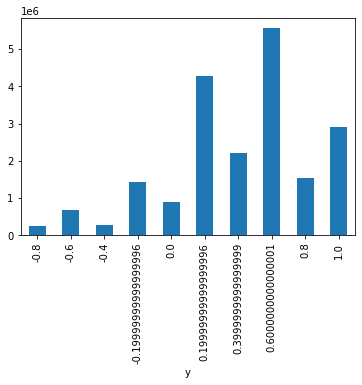

In [10]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

In [11]:
# Loading movie
movies = pd.read_csv(fpath+'/movies.csv')
movies["year"]=movies["title"].apply(lambda x: x[-5:-1])
movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
movies["title"]= movies["title"].apply(lambda x: x[0:-7])
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


# Model v2.3
Sử dụng constrastive loss thay cho onehot

In [12]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [13]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

In [14]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

top_k_item = 5000
wu_size = 200
mask_size = 50
max_item = wu_size + mask_size

interac_df, top_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<3000]
                    , max_item = max_item
                    , top_k_item = top_k_item )
interac_df

,movieId,y
userId,,
1,"[8507, 7153, 8636, 6539, 8368, 6093, 1079, 262...","[1.0, 1.0, 0.8, 0.6000000000000001, 0.60000000..."
2,"[3930, 480, 70, 2948, 3927, 1356, 260, 1974, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[223, 1242, 2076, 1321, 2118, 2150, 480, 3039,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[733, 454, 520, 10, 596, 377, 368, 594, 489, 5...","[1.0, 1.0, 0.6000000000000001, 0.6000000000000..."
5,"[720, 380, 11, 1079, 594, 1028, 531, 141, 1196...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
2995,"[356, 1060, 2387, 1220, 2502, 1704, 1917, 2028...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2996,"[4973, 2278, 2288, 5902, 2600, 1214, 2427, 128...","[0.8, 0.8, 0.8, 0.8, 0.6000000000000001, 0.600..."
2997,"[1073, 2324, 923, 2080, 1923, 296, 588, 1196, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


### Class  model

In [15]:
# Khởi tạo cấu hình: xác định encoder, decoder, mapping dims
class Efficient_Rec(tf.keras.Model):
  def __init__(self, encoder, decoder, reps, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [16]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [17]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [18]:
# Thực hiện training
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [19]:
# Thực hiện minibatch training
def _batch_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._train_step(chunk)

Efficient_Rec._batch_train_step = _batch_train_step

In [20]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _constrastive_train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs.sample(frac=1), mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])


        average_loss = self.loss(wu_vec, mask_vec, negative_vec) #- 0.1*np.mean([tf.linalg.norm(x) for x in self.trainable_variables])

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
                 for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._constrastive_train_step = _constrastive_train_step

In [21]:
# Thực hiện minibatch training
def _constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
    return np.mean(losses)

Efficient_Rec._constrastive_train_minibatch_step = _constrastive_train_minibatch_step

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [22]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 193 ms, sys: 23.8 ms, total: 216 ms
Wall time: 494 ms


In [23]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs

        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y

In [76]:
# Xây dựng mạng
embedding_size = 173
reps_size = 132
cluster_num = 43

@tf.function
def avg_layer(z):
    deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1)
    t = K.sum(z[0], axis=1)/deno
    t = tf.clip_by_value( t, -1, 1 )
    t = tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    return t
    # if tf.reduce_sum(deno) >0 :
    #     return  
    # else:
    #     return K.sum(z[0], axis=1)


def interaction_embedding2():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= False, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: avg_layer(z) )([ireps, wr])
    # uprofile = layers.Lambda(lambda z: K.sum(z, axis=1) )(ireps)
    # uprofile = layers.LayerNormalization(name='norm')(uprofile)

    # uprofile = layers.Dense( reps_size, activation='linear', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [23]:
# def avg_layer(z):
#     print(tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1))
#     deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1)
#     print("deno",deno)
#     # if deno >0 :
#     return  K.sum(z[0], axis=1)/deno
#     # else:
#     #     return K.sum(z[0], axis=1)

# input_wi = [" "]

# vectorizer = layers.TextVectorization( max_tokens= 5, split='whitespace', output_sequence_length= 3)
# vectorizer.adapt( ["2 1"] ) 

# wi = vectorizer(input_wi)
# print(wi)
# wi = layers.Embedding(input_dim= max_vocab_size, output_dim= 2, mask_zero= False, name='ei')(wi)
# print(wi)
# wi = layers.Dense(2, activation='relu', name='di', use_bias=0)(wi)
# print(wi)

# wr = np.array([0.,0.,0.])


# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print(ireps)
# uprofile = layers.Lambda(lambda z: avg_layer(z) )([ireps, wr])
# print(uprofile)

In [24]:
# Kiểm tra tham số
# encode_model.summary()

In [25]:
# tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

### Constrastive model

In [659]:
def cossim(a, b):
    def l2(a):
        return tf.sqrt( tf.reduce_sum(tf.square(a), axis=1) )
    return tf.reduce_sum(tf.multiply(a, b), axis=1)/(l2(a)*l2(b))
    
def constrastive_loss(margin=0.01):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        # ap_distance = tf.linalg.norm(wu_vec - mask_vec, axis=1)
        # an_distance = tf.linalg.norm(wu_vec - negative_vec, axis=1)
        ap_distance = 1-cossim(wu_vec , mask_vec)
        an_distance = 1-cossim(wu_vec , negative_vec)
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        print(loss)
        loss = tf.maximum(loss + margin, 0.)
        # tf.print(loss)
        loss =tf.reduce_mean(loss)
        return loss
    return compute_loss

def circle_loss(margin=0.01, gama=0.05):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        sp = cossim(wu_vec , mask_vec)
        sn = cossim(wu_vec , negative_vec)

        loss = gama*tf.math.exp(sn - sp + margin, 0)
        # loss = tf.math.log(1+ loss)
        loss = tf.reduce_mean(loss)

        return loss
    return compute_loss


# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = None, #get_reps_model(),
                      decoder = None ,# mask_label(),
                      use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss= circle_loss(margin= 0.5, gama=1.),
)

In [660]:
%%time
epochs= 20
for n in range(epochs):
  print(n, "/", epochs, ": ", model._constrastive_train_minibatch_step( interac_df, batch_size = 520 ))
gc.collect()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6491014>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6487514>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6463856>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6437634>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6401808>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6292735>}
0 / 20 :  1.6429094
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6324836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6264927>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6367166>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6233107>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6371998>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6487216>}
1 / 20 :  1.6341542
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6487216>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32

KeyboardInterrupt: ignored

In [661]:
# model.layers[0].layers

In [662]:
# np.expand_dims(np.roll(interac_df["movieId"].apply(lambda x:' '.join([str(i) for i in x])), 1), -1)

// END constrastive model

In [83]:
# Kiểm tra giá trị đầu ra
group_scores = model.encoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = wu_size )).numpy()
print( np.max(group_scores), np.mean(group_scores), np.min(group_scores) )
group_scores[0:3]

0.9408499 0.36156797 0.0056684017


array([[0.30227214, 0.2857681 , 0.43020117, 0.40602407, 0.27726805,
        0.32778803, 0.22956929, 0.3728376 , 0.34225726, 0.28993312,
        0.34082717, 0.24571961, 0.3063588 , 0.22028762, 0.26402703,
        0.2555788 , 0.35689223, 0.48779207, 0.26599455, 0.4829004 ,
        0.41772628, 0.5160603 , 0.30147743, 0.33360547, 0.42918167,
        0.21152794, 0.3418494 , 0.30531555, 0.4066321 , 0.32988322,
        0.41300195, 0.3867893 , 0.41671416, 0.39925984, 0.47400656,
        0.3626796 , 0.21375605, 0.4336968 , 0.27379072, 0.4997945 ,
        0.28192532, 0.21703193, 0.4613739 ],
       [0.2160536 , 0.27463228, 0.36994606, 0.31172115, 0.25544012,
        0.12246624, 0.29012877, 0.42702013, 0.22936049, 0.14870736,
        0.3089757 , 0.24005777, 0.3383001 , 0.15091446, 0.2045848 ,
        0.13663363, 0.18365961, 0.69450724, 0.24154958, 0.43242472,
        0.38308734, 0.6831361 , 0.15181506, 0.2672851 , 0.30525917,
        0.1723786 , 0.28846872, 0.382487  , 0.62359536, 0.23450321,
   

# Label data

In [51]:
# movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
# movie_genres = movies.explode("genres_list")
# sample = warm_up_mask[warm_up_mask[userCol]<3000]

# gr = sample.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
# gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

# labels = gr[gr["rank"] ==1].set_index("userId")

In [84]:
labels["pred_max_ind"] = np.argmax(group_scores, axis=1)

In [91]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
# tsne = PCA(n_components=2, random_state=123)
z = tsne.fit_transform(group_scores) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2999 samples in 0.001s...
[t-SNE] Computed neighbors for 2999 samples in 0.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2999
[t-SNE] Computed conditional probabilities for sample 2000 / 2999
[t-SNE] Computed conditional probabilities for sample 2999 / 2999
[t-SNE] Mean sigma: 0.101735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.406914
[t-SNE] KL divergence after 1000 iterations: 1.025208


In [92]:
df = pd.DataFrame()
df["y"] = labels["genres_list"]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

In [95]:
plt.rcParams["figure.figsize"] = (8,8)
# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette="Paired" ,#sns.color_palette("hls", 3),
#                 data=df)#.set(title="Iris data T-SNE projection") 

In [88]:
# Kiểm tra số user trong mỗi cụm có bị vón cục
ugs= np.argmax(group_scores, axis=1)
for i in range(50):
    print(i,': ', np.sum(ugs==i) )


0 :  0
1 :  0
2 :  93
3 :  306
4 :  0
5 :  200
6 :  0
7 :  0
8 :  0
9 :  216
10 :  0
11 :  0
12 :  0
13 :  0
14 :  0
15 :  1
16 :  37
17 :  269
18 :  0
19 :  250
20 :  9
21 :  49
22 :  0
23 :  0
24 :  205
25 :  0
26 :  0
27 :  0
28 :  0
29 :  0
30 :  470
31 :  112
32 :  56
33 :  0
34 :  237
35 :  0
36 :  0
37 :  21
38 :  0
39 :  461
40 :  0
41 :  0
42 :  7
43 :  0
44 :  0
45 :  0
46 :  0
47 :  0
48 :  0
49 :  0


In [94]:
# Sort theo user_group + draw sigmoid/softmax layer
plt.rcParams["figure.figsize"] = (20,10)
k =200
a = group_scores
ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[np.argsort(ind)][0:k] )

In [672]:
# np.argsort(a[1])

In [673]:
# [np.isin(np.argsort(a[1]), np.array([0,1,2]) )]

In [674]:
# Vẽ theo user_group
# user_groups = [ 32 ]
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[ np.isin( ind, user_groups)] )

In [675]:
# Vẽ y_true của các user chung group
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
# y_true_ugrs = y_true[ np.isin( ind, user_groups)]

# for i in range(y_true_ugrs.shape[0]):
#     y_true_i = y_true_ugrs[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()


In [676]:
# plt.imshow(y_true[0].reshape(50, 100) )

In [677]:
# y_true[0][y_true[0]!=0]

In [678]:
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()[0:15]
# for i in range(y_true.shape[0]):
#     y_true_i = y_true[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()

In [679]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

In [680]:
# plt.imshow(y_true)

# supervised constrastive 

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 23.4 MB/s 


In [37]:
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder

In [69]:
interac_df

,movieId,y
userId,,
1,"[8507, 7153, 8636, 6539, 8368, 6093, 1079, 262...","[1.0, 1.0, 0.8, 0.6000000000000001, 0.60000000..."
2,"[3930, 480, 70, 2948, 3927, 1356, 260, 1974, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[223, 1242, 2076, 1321, 2118, 2150, 480, 3039,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[733, 454, 520, 10, 596, 377, 368, 594, 489, 5...","[1.0, 1.0, 0.6000000000000001, 0.6000000000000..."
5,"[720, 380, 11, 1079, 594, 1028, 531, 141, 1196...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
2995,"[356, 1060, 2387, 1220, 2502, 1704, 1917, 2028...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2996,"[4973, 2278, 2288, 5902, 2600, 1214, 2427, 128...","[0.8, 0.8, 0.8, 0.8, 0.6000000000000001, 0.600..."
2997,"[1073, 2324, 923, 2080, 1923, 296, 588, 1196, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [77]:
label_enc = LabelEncoder()
labels["label"] = label_enc.fit_transform(labels["genres_list"])

In [78]:
labels

,genres_list,movieId,rank,pred_max_ind,label
userId,,,,,
1,Adventure,43,1.0,1,1
2,Action,16,1.0,31,0
3,Sci-Fi,58,1.0,1,12
4,Action,8,1.0,1,0
5,Comedy,15,1.0,40,4
...,...,...,...,...,...
2995,Comedy,77,1.0,4,4
2996,Action,11,1.0,1,0
2997,Drama,38,1.0,40,6


In [79]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [80]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _supervised_constrastive_train_step(self, inputs):
    items_pd, ratings_pd, labels = inputs
    items, ratings = self._preprocess((items_pd, ratings_pd), wu_size)

    with tf.GradientTape() as tape:
        # Interaction embedding
        vec = self.encoder([items, ratings])

        average_loss = self.loss(labels, vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
                 for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._supervised_constrastive_train_step = _supervised_constrastive_train_step

In [81]:

# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = None, #get_reps_model(),
                      decoder = None ,# mask_label(),
                      use_tf_function=False)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.001),
    loss= SupervisedContrastiveLoss(temperature = 0.05),
)

In [82]:
%%time
epochs= 20
for n in range(epochs):
  print(n, "/", epochs, ": ", model._supervised_constrastive_train_step( (interac_df["movieId"], interac_df["y"], labels["label"]) ))
gc.collect()

0 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.005782>}
1 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.005298>}
2 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.004307>}
3 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.002416>}
4 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.999133>}
5 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.993842>}
6 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.98565>}
7 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.973509>}
8 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.956508>}
9 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.9340706>}
10 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.9065156>}
11 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8752313>}
12 / 20 :  {'batch_loss': <tf.Tensor: shape=(), 

In [ ]:
gc.collect()